# Beyond the Burn: Fire Scars and Social Impacts of the Palisades and Eaton Fires
**Repository:** https://github.com/vedikaS-byte/fire-scars-and-social-impacts-analysis

## About

In January 2025, Los Angeles County experienced two catastrophic fires: the Eaton and Palisades Fires. Each fire burned nearly 10,000 acres and forced thousands of residents to evacuate (Neuman, 2025). Strong Santa Ana winds intensified the fires, complicating containment efforts, as the flames not only funneled through mountain passes but also spread over ridges and into surrounding basins (Neuman, 2025). The fires caused widespread displacement, killed at least 28 people, destroyed over 16,000 structures, and inflicted significant ecological damage (Phillips, 2025).

![eaton_fire.jpeg](https://ewscripps.brightspotcdn.com/dims4/default/5ddece7/2147483647/strip/true/crop/6000x3375+0+314/resize/1280x720!/quality/90/?url=http%3A%2F%2Fewscripps-brightspot.s3.amazonaws.com%2F15%2F49%2F126ae4bc4dcf97cc1ab28b55d1fe%2Fap25008142636991.jpg)
**Figure 1. Palisades Fires burning through a residential neighborhood in Los Angeles during high winds in early January (ABC News, 2025).**


This blog post includes two main components: Visualizing Fire Scars with False Color Imagery and Exploring the Social Dimensions of Fire Impacts. It walks through how I applied geospatial analysis and worked with environmental datasets using Python libraries such as `geopandas` and `xarray`, including reassigning spatial reference information to ensure accurate georeferencing. In the second part, I explore how performing a spatial join and clipping can yield different results when relating geospatial datasets using socioeconomic data. 

The final outputs include a false color map of the Palisades and Eaton fires created from remote sensing data to highlight fire scars and demonstrate how coding and data visualization can support environmental monitoring. I also created a map of census tracts showing households living below 200% of the poverty level within the affected areas to better understand the social impacts of each fire. I explored the difference between spatial joins and spatial clipping when linking geospatial datasets to a reference boundary, comparing both methods to determine which best represented the population living below 200% of the poverty line in each fire perimeter. The primary socioeconomic variable for this analysis comes from the 2024 Environmental Justice Index (EJI) geodatabase (`EPL_POV200`).

### Key Highlights

- **Remote sensing allows for quantitative and spatial mapping of fire impact, and false color imagery provides detailed insight into vegetation changes.** Using Python tools such as `xarray` and `geopandas`, the satellite raster data was processed to map fire-scar perimeters and generate true and false color imagery that clearly distinguishes burned areas from healthy vegetation, providing precise spatial context and improved interpretation of affected landscapes (Earth Observatory, 2025).


- **The coordinate reference system (CRS) is important when handling and mapping multiple geospatial objects to ensure accurate spatial analysis**. When combining multiple geospatial datasets (ex. fire perimeters and satellite imagery), having consistent CRS prevents misalignment, ensures correct distance and area measurements, and allows layers to overlay properly on maps.


- **Geospatial information can be assigned to an object using a spatial reference.** In this analysis, the EPSG code embedded in the `.spatial_ref.crs_wkt` output was identified and used to properly assign and (if needed) reproject the dataset.


- **Performing a spatial join and clipping can produce different results.** When an `intersects` spatial join between the census tracts and fire perimeters was performed, the output included entire census tracts that touched the fire perimeter, resulting in a larger extent. This differs from clipping, which would limit the output strictly to the area within the fire perimeter.

### Data Description
This analysis utilized two datasets. The first is a simplified set of satellite image bands (red, green, blue, near-infrared, and shortwave infrared) from the Landsat 8 satellite, downloaded from the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and trimmed to the fire area. It is used only for visualization and learning and is provided as `landsat8-2025-02-23-palisades-eaton.nc` in the EDS 220 course resources.


The second dataset shows the burned areas for the Palisades and Eaton fires. The fire boundary shapefiles were downloaded from the [County of Los Angeles Enterprise GIS](https://egis-lacounty.hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about). Each fire originally had daily mapped boundaries, which were combined (dissolved) into one final outline showing the total area burned by each fire (County of Los Angeles, 2025).

The third dataset contains 2024 socioeconomic data for California, downloaded as a geodatabase from the [2024 Environmental Justice Index](https://www.atsdr.cdc.gov/place-health/php/eji/eji-data-download.html) (EJI). The dataset was downloaded from the Agency for Toxic Substances and Disease Registry and contains environmental, economic, and demographic data at the census track level. 

### Data References

Bren School of Environmental Science and Management. (2025). *landsat8-2025-02-23-palisades-eaton.nc* [Dataset]. Accessed November 20, 2025, from https://drive.google.com/drive/u/1/folders/1USqhiMLyN8GE05B8WJmHabviJGnmAsLP


Centers for Disease Control and Prevention and Agency for Toxic Substances Disease Registry. (2024). *2024 Environmental Justice Index*. [Dataset]. Accessed December 2, 2025, from 
https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html



County of Los Angeles Enterprise GIS. (2025). *Palisades and Eaton Dissolved Fire Perimeters (2025)* [Dataset]. County of Los Angeles. Accessed November 20, 2025, from 
https://egis-lacounty.hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about



Microsoft Planetary Computer. (n.d.). *Landsat Collection 2 Level-2*. Accessed November 20, 2025, from https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2


## Import Necessary Libraries

In [78]:
# Import necessary libraries along with defined abbreviations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd 
import xarray as xarray
import contextily as ctx

## Reading in Shapefiles, Satellite Imagery, and EJI Data

Here, I loaded each fire perimeter using a defined file path. I also loaded the NetCDF file (`landsat8-2025-02-23-palisades-eaton.nc`) containing the satellite imagery, as well as the Environmental Justice Index (EJI) geodatabase using its file path.

In [79]:
# Set up display options when looking at data frames
pd.set_option("display.max.columns", None)

# Establish file path to read in eaton shapefile
eaton_fp = os.path.join("data", "Eaton_Perimeter_20250121", 
                        "Eaton_Perimeter_20250121.shp")
eaton = gpd.read_file(eaton_fp)

# Establish file path to read in palisades shapefile
palisades_fp = os.path.join("data", "Palisades_Perimeter_20250121", 
                            "Palisades_Perimeter_20250121.shp")
palisades = gpd.read_file(palisades_fp)

# Establish file path to read in and open landsat data 
fp = "data/landsat8-2025-02-23-palisades-eaton.nc"
palisades_eaton = xarray.open_dataset(fp)

# Establish EJI file path to read in EJI geodatabase
eji_fp = os.path.join("data", "EJI_2024_California", "EJI_2024_California.gdb")
eji = gpd.read_file(eji_fp)

## Visualizing the Extent of Burns in False Color

### Part 1: Fire Perimeter and Satellite Imagery Data Exploration
I explored the Palisades and Eaton fire perimeter shapefiles and the Landsat imagery (imported as a NetCDF file), and summarized key observations with brief descriptions.

#### Exploring the Eaton Fire Shapefile

In [80]:
# Explore data types, dimensions, and additional attributes
eaton.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    20 non-null     int64   
 1   type        20 non-null     object  
 2   Shape__Are  20 non-null     float64 
 3   Shape__Len  20 non-null     float64 
 4   geometry    20 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 932.0+ bytes


In [81]:
# Check the projected CRS
print(f"CRS of Eaton shapefile: {eaton.crs.name} ({eaton.crs}).") 

CRS of Eaton shapefile: WGS 84 / Pseudo-Mercator (EPSG:3857).


The `eaton` fire perimeter dataset includes five attributes: `OBJECTID`, `type`, `Shape__Are`, `Shape__Len`, and a `geometry`. The `OBJECTID` variable is stored as an `int64`, `type` appears as an `object` (likely a string), and both `Shape__Are` and `Shape__Len` are represented as `float64` values, while the `geometry` column stores spatial features. All 20 records are complete with no missing values observed. The `eaton` shapefile, loaded as a `geopandas GeoDataFrame`, is projected and is stored in the WGS 84 / Pseudo-Mercator CRS, identified by EPSG code 3857. 

#### Exploring the Palisades Fire Shapefile

In [82]:
# Explore data types, dimensions, and additional attributes
palisades.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    21 non-null     int64   
 1   type        21 non-null     object  
 2   Shape__Are  21 non-null     float64 
 3   Shape__Len  21 non-null     float64 
 4   geometry    21 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 972.0+ bytes


In [83]:
# Check the projected CRS
print(f"CRS of Palisades shapefile: {palisades.crs.name} ({palisades.crs}).")

CRS of Palisades shapefile: WGS 84 / Pseudo-Mercator (EPSG:3857).


The `palisades` fire perimeter dataset includes five attributes: `OBJECTID`, `type`, `Shape__Are`, `Shape__Len`, and a `geometry`. The `OBJECTID` variable is stored as an `int64`, `type` appears as an `object` (likely a string), and both `Shape__Are` and `Shape__Len` are represented as `float64` values, while the `geometry` column stores spatial features. All 21 records are complete with no missing values observed. The `palisades` shapefile, loaded as a `geopandas GeoDataFrame`, is projected and stored in the WGS 84 / Pseudo-Mercator CRS, identified by EPSG code 3857. 

#### Exploring the NetCDF Satellite Imagery

In [84]:
# Observe variables as well as their attributes and dimensions
palisades_eaton

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

The netCDF palisades_eaton, read in as an `xarray.core.dataset.Dataset`, contains five variables observed from the raw output: `red`, `green`, `blue`, `nir08`, `swir22`, and `spatial_ref`. All color bands are stored as `float32` types while `spatial_ref` is an `int64` type. `palisades_eaton` is structured as a two-dimensional grid with dimensions of 1418 (y) by 2742 (x). The x coordinates span 334,410 to 416,640 units and the y coordinates from 3,756,540 to 3,799,050 units. The temporal coordinate shows a single time of 2025-02-23T18:28:13.651369000.

### Part 2: Restoring Geospatial Information to the NetCDF
As observed in this section, the NetCDF file (`palisades_eaton`) was not automatically recognized as a geospatial object. Although it contained spatial reference information, it was loaded as a basic `xarray.Dataset` and did not have a defined coordinate reference system (CRS), as shown by the empty output from `rio.crs`.

In [85]:
# Call rio.crs on palisades_eaton to check for geospatial information
palisades_eaton.rio.crs # There is no output generated

To continue with the analysis, I needed to restore the spatial information by assigning the correct CRS. I used the `write_crs()` function through the `rio` accessor to reattach the geospatial reference and project the Landsat data to EPSG:32611, which I identified from the NetCDF using `spatial_ref.crs_wkt`.

In [86]:
# Call spatial_red.crs_wkt on netCDF to access geospatial reference info
palisades_eaton.spatial_ref.crs_wkt

'PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]'

In [87]:
# Assign the EPSG:32611 CRS to palisades_eaton 
palisades_eaton = palisades_eaton.rio.write_crs(32611)

### Part 3: Visualizing the Extent of Burns in False Color
I utilized false color imagery to highlight the extent of the Palisades and Eaton fire scars in Los Angeles County by combining the shortwave infrared (`swir22`), near-infrared (`nir08`), and red bands. This view allowed burned areas and changes in vegetation to be more visible. Before plotting, I also ensured that all geospatial datasets shared the CRS by  applying transformations with conditional statements as needed to prevent geospatial misalignment.

In [88]:
# Landsat CRS is the reference CRS used for transformation
crs_raster = palisades_eaton.rio.crs

# Transform to match CRS reference
if palisades.crs != crs_raster: 
    palisades = palisades.to_crs(crs_raster)

# Transform to match CRS reference
if eaton.crs != crs_raster: 
    eaton = eaton.to_crs(crs_raster)

In the final step of my analysis, I created a map using this false color combination and included a figure description to explain how it highlights burned regions and vegetation patterns. At first, the image did not plot correctly due to missing (`NaN`) values in some bands; however,  replacing those values with zeros using `.fillna(0)` and reducing the influence of outliers such as clouds with `robust = True` generated a corrected image that clearly outlines fire scars across the landscape.

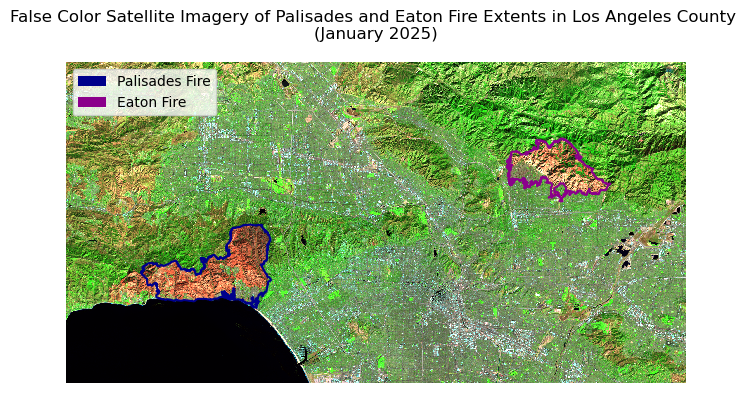

In [89]:
# Establish figure and axis
fig, ax = plt.subplots(figsize = (8,10))

# Define bands of interest
bands = palisades_eaton[["swir22", "nir08","red"]].to_array().fillna(0)

bands.plot.imshow(
    ax = ax, # Assign axis
    robust = True # No cloud cover
    ) 

# Manually create patches for referencing fire perimeter in legend 
palisades_patch = mpatches.Patch(
    facecolor = "darkblue", # Define border color (fill for patch)
    label = "Palisades Fire") # Label reference

eaton_patch = mpatches.Patch(
    facecolor = "darkmagenta", # Define border color (fill for patch)
    label = "Eaton Fire") # Label reference

# Plot each fire perimeter with same edgecolor as patch
palisades.plot(ax = ax, # Reassign axis
               facecolor = "none", # No fill color
               edgecolor = "darkblue", # Border color
               label = "Palisades Fire", # Label
               linewidth= 1.5) # Adjust border thickness

eaton.plot(ax = ax, 
           facecolor = "none", # No fill color
           edgecolor = "darkmagenta", # Border color
           label = "Eaton Fire", # Label
           linewidth = 1.5) # Adjust border thickness

# Add legend 
ax.legend( 
    handles = [palisades_patch, eaton_patch], # Pass list of patches
    loc = "upper left") # Define location for legend

# Set a title
ax.set_title(
    "False Color Satellite Imagery of Palisades and Eaton Fire Extents in Los Angeles County \n(January 2025)"
)

# Turn axis off for readability
ax.set_axis_off()

# Show plot
plt.show()

**Map 1. False color imagery of Palisades and Eaton Fire extent in Los Angeles County (January 2025).**

The produced map highlights the significant impact of the Palisades and Eaton Fires on vegetation density. In the burned areas, an orange coloration clearly contrasts with the surrounding greenery, indicating that the fires heavily affected forested regions. The Palisades Fire appears to have burned a larger area than the Eaton Fire, with more extensive vegetation loss within its perimeter. Additionally, the Palisades Fire is situated closer to the coast and urban areas, suggesting a potentially greater direct impact on people, though the Eaton Fire also affected populated regions.

The false color imagery uses the shortwave infrared (SWIR), near-infrared (NIR), and red bands to enhance contrasts in vegetation. For instance, mountainous areas outside the fire perimeters appear as dense light green, while urban regions are represented by clusters of white, likely indicating building presence. Within each fire perimeter, reduced vegetation density is highlighted in orange, clearly outlining burned areas from the surrounding greener regions.

## Visualizing Social Dimensions of the Fires

### Part 1: Spatial Joining vs Spatial Clipping
A spatial join returns attributes from one or both `GeoDataFrames` based on their spatial relationship, such as whether features intersect, overlap, or are contained within one another; it merges attribute data using spatial rules. A spatial clip, on the other hand, simply limits one `GeoDataFrame` to the area defined by another. It cuts the geometries using a mask and returns only the attributes from the original dataset being clipped, without merging in new attribute information.

To visually understand the difference between clipping and spatial joining, I applied both methods to the census tracts in two subsections using the fire perimeters as the reference layer. Before proceeding, I verified that all geospatial layers were projected using the same CRS.

In [90]:
# Reproject EJI to match Palisades CRS if needed
if eji.crs != palisades.crs:
    eji = eji.to_crs(palisades.crs)

# Reproject EJI to match Eaton CRS if needed
if eji.crs != eaton.crs:
    eji = eji.to_crs(eaton.crs)

#### Spatially Joining Census Tracts and Fire Perimeters 
In this section, I explored and visualized spatial joins by using the EJI data with the Palisades and Eaton fire perimeters through `sjoin()`. 

In [91]:
# Only include EJI census tracts that intersect the Palisades fire perimeter
eji_palisades = gpd.sjoin(eji, palisades, predicate = "intersects")

In [92]:
# Only include EJI census tracts that intersect the Eaton fire perimeter
eji_eaton = gpd.sjoin(eji, eaton, predicate = "intersects")

<function matplotlib.pyplot.show(close=None, block=None)>

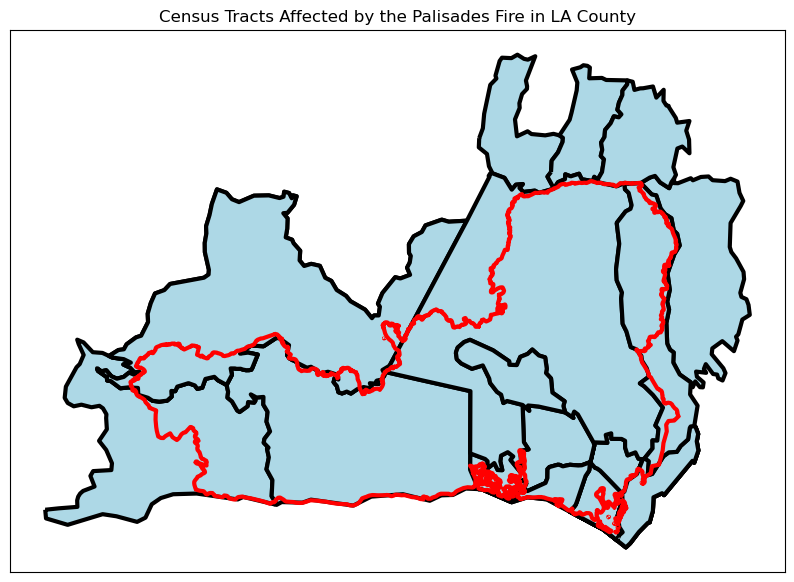

In [93]:
## Map the intersecting census tracts compared to the Palisades fire perimeter

# Define figure and axis dimensions
fig, ax = plt.subplots(figsize = (10,8))

# Plot intersection of eji census tracts with palisades perimeter
eji_palisades.plot(ax= ax, edgecolor = "black",  facecolor = "lightblue", linewidth = 3)

# Plot palisades perimeter (outlined in red) for reference
palisades.plot(ax = ax, color = "none", edgecolor = "red", linewidth = 3)

# Set title
ax.set_title("Census Tracts Affected by the Palisades Fire in LA County")

# Turn of axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Call plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

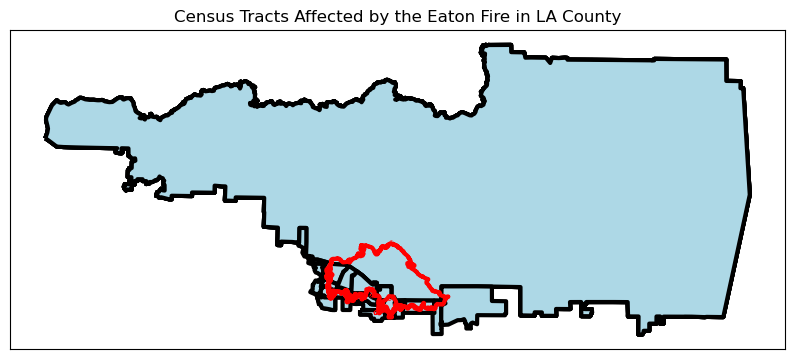

In [94]:
## Map the intersecting census tracts compared to the Palisades fire perimeter

# Define figure and axis dimensions
fig, ax = plt.subplots(figsize = (10,8))

# Plot intersection of eji census tracts with eaton perimeter
eji_eaton.plot(ax= ax, edgecolor = "black",  facecolor = "lightblue", linewidth = 3)

# Plot eaton perimeter (outlined in red) for reference
eaton.plot(ax = ax, color = "none", edgecolor = "red", linewidth = 3)

# Set title
ax.set_title("Census Tracts Affected by the Eaton Fire in LA County")

# Turn of axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Call plot
plt.show

#### Clipping Census Tracts to Fire Perimeters

An alternative to using a spatial join is clipping, which restricts one geospatial dataset to the extent of another. Here, I used `geopandas.clip()` instead of a spatial join to limit the census tracts to the boundaries of each fire.

In [95]:
# Clip the census tracts to the extent of the palisades perimeter
eji_palisades_clip = gpd.clip(eji, palisades)

In [96]:
# Clip the census tracts to the extent of the eaton perimeter
eji_eaton_clip = gpd.clip(eji, eaton)

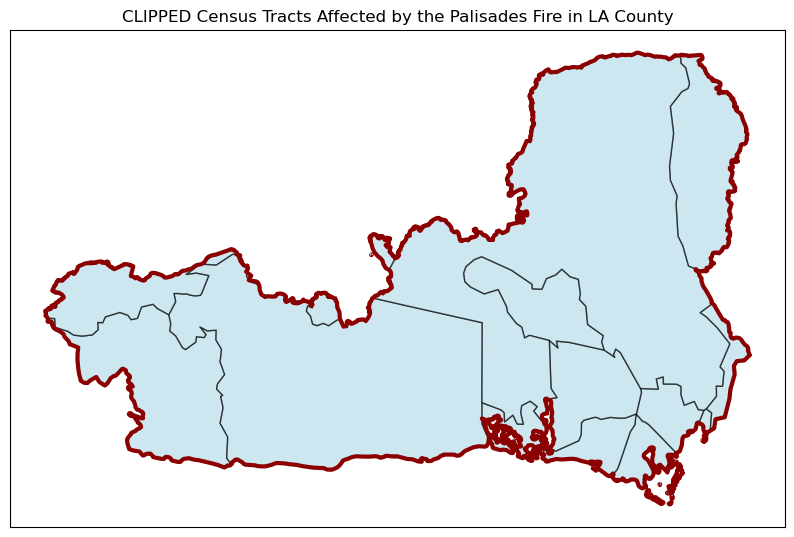

In [97]:
## Plot clipped census tracts to the Palisades fire perimeter
# Define figure and axis
fig, ax = plt.subplots(figsize = (10,8))

# Plot clipped census tracts within the Palisades fire perimeter (filled in light blue, outlined in black)
eji_palisades_clip.plot(ax = ax, facecolor = "lightblue", edgecolor = "black", linewidth = 1, alpha = .6)

# Plot palisades perimeter (outlined in dark red) for reference
palisades.plot(ax = ax, color = "none", edgecolor = "darkred", linewidth = 3)

# Set title
ax.set_title("CLIPPED Census Tracts Affected by the Palisades Fire in LA County")

# Turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Call plot
plt.show()

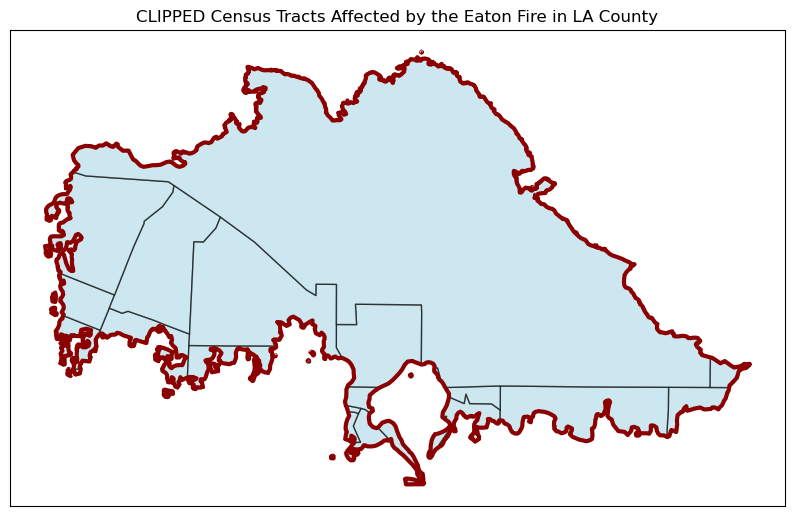

In [98]:
## Plot clipped census tracts to the Eaton fire perimeter

# Define figure and axis
fig, ax = plt.subplots(figsize = (10,8))

# Plot clipped census tracts within the Eaton fire perimeter (filled in light blue, outlined in black)
eji_eaton_clip.plot(ax = ax, facecolor = "lightblue", edgecolor = "black", linewidth = 1, alpha = .6)

# Plot eaton perimeter (outlined in dark red) for reference
eaton.plot(ax = ax, color = "none", edgecolor = "darkred", linewidth = 3)

# Set title
ax.set_title("CLIPPED Census Tracts Affected by the Eaton Fire in LA County")

# Turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Call plot
plt.show()

### Part 2: Mapping Environmental Justice Data in Affected Areas
For visualizing census tracts based on social conditions within each fire perimeter, clipping is preferred because clipping limits the data to only the portions of census tracts that fall inside the fire boundaries, rather than including entire tracts that touch the perimeter. With an `intersects` spatial join, whole census tracts were returned even if only a small portion overlapped the fire area, which resulted in larger extents than the actual fire boundaries. 

Here, I mapped the clipped census tracts within each fire perimeter to visualize the varying percentages of the population in each tract living below 200% of the poverty line.

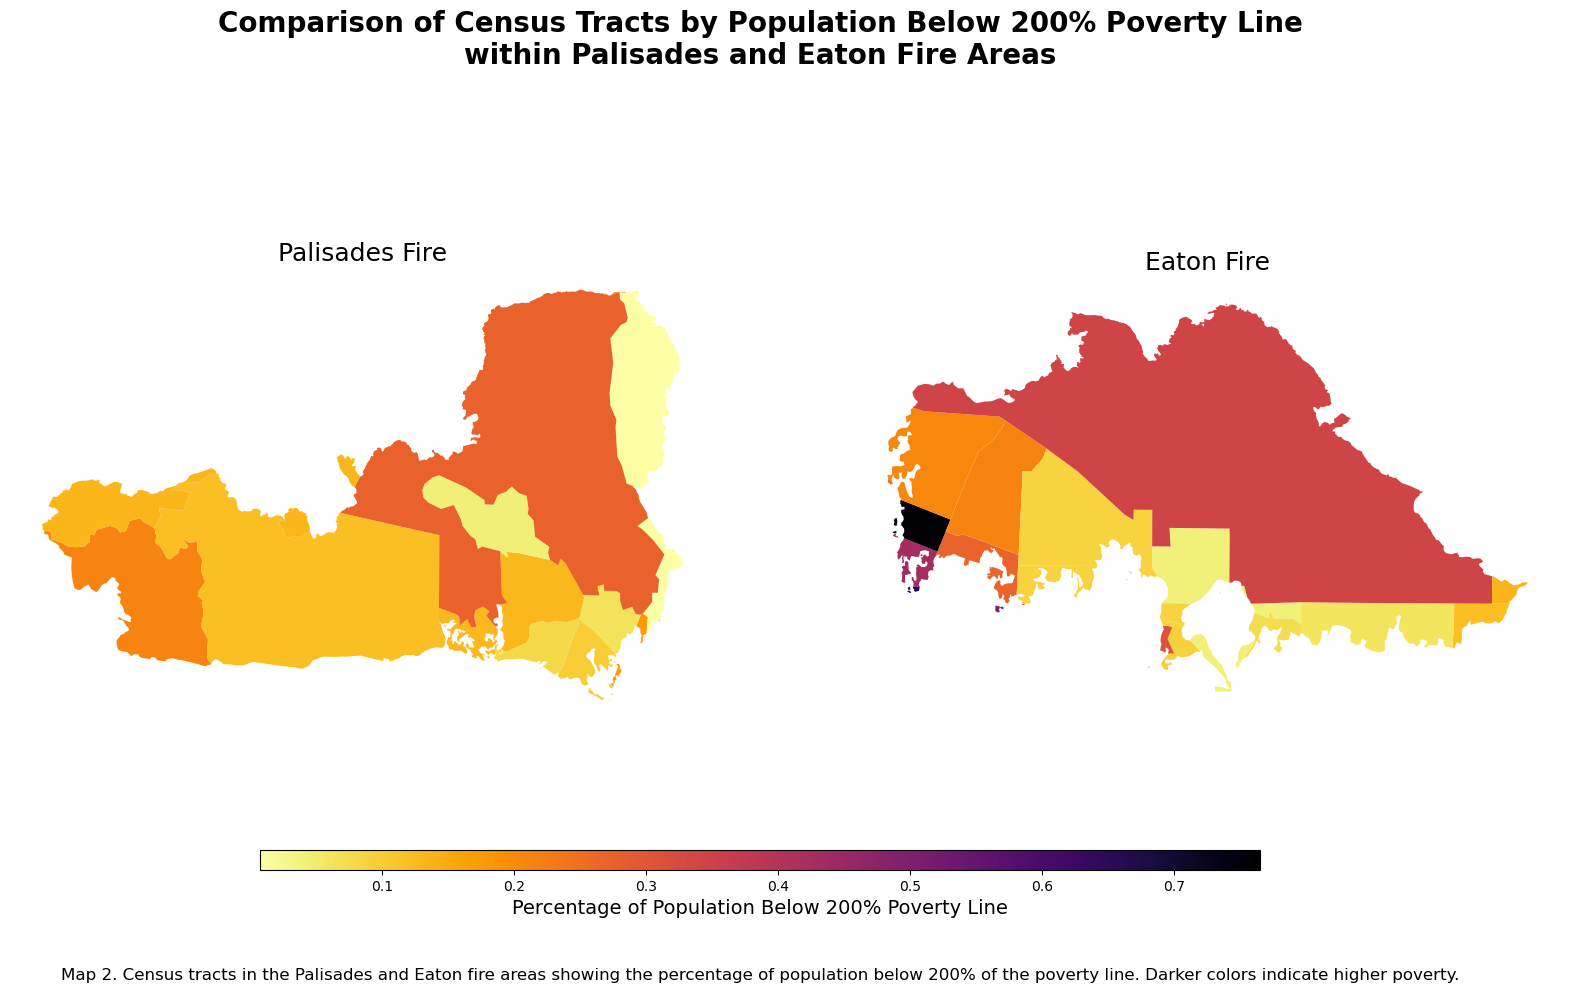

In [99]:
# Create subplots for Palisades and Eaton fires
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Update eji variable
eji_variable = 'EPL_POV200'

# Determine common min/max values for consistent color scale across both plots
vmin = min(eji_palisades_clip[eji_variable].min(), eji_eaton_clip[eji_variable].min())
vmax = max(eji_palisades_clip[eji_variable].max(), eji_eaton_clip[eji_variable].max())

# Plot clipped census tracts within Palisades fire perimeter
eji_palisades_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
    cmap="inferno_r"
)
ax1.set_title('Palisades Fire', fontsize=18)  # Larger title
ax1.axis('off')

# Plot clipped census tracts within Eaton fire perimeter
eji_eaton_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
    cmap="inferno_r"
)
ax2.set_title('Eaton Fire', fontsize=18)  # Larger title
ax2.axis('off')

# Add descriptive title 
fig.suptitle(
    'Comparison of Census Tracts by Population Below 200% Poverty Line\nwithin Palisades and Eaton Fire Areas',
    fontsize=20,
    fontweight='bold'
)

# Add shared colorbar at  bottom
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap="inferno_r")
cbar_ax = fig.add_axes([0.25, 0.12, 0.5, 0.02])  # [left, bottom, width, height], adjust to raise y-axis 
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percentage of Population Below 200% Poverty Line', fontsize=14)

# Add caption
fig.text(
    0.5, 0.01, # Adjust approximate position
    "Map 2. Census tracts in the Palisades and Eaton fire areas showing the percentage of population below 200% of the poverty line. Darker colors indicate higher poverty.",
    ha='center', # Position
    fontsize= 12 # Adjust font size
)

plt.show()

From the figure, it is evident that a higher percentage of lower-poverty communities were affected by the Palisades Fire compared to higher-poverty areas. In contrast, only a single census tract impacted by the Eaton Fire had more than 70% of its population living below 200% of the poverty line. Notably, larger census tracts tended to have at least 30-40% of residents living in poverty. This suggests that higher-income communities, often located in wealthier neighborhoods, may have been more affected by the Palisades Fire. Additionally, within the Palisades Fire extent, census tracts further from the coastline generally exhibited higher poverty rates than those closer to the coast. For the Eaton Fire, poorer census tracts were more frequently found in the mountainous regions affected by the fire. Generally, the Eaton Fire affected census tracts with higher proportions of residents living below 200% of the poverty line compared to the Palisades Fire. Overall, the analysis demonstrates that the effects of wildfires can vary significantly depending on the socioeconomic characteristics of affected communities. 